In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
#import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from train_snippets import train_model


In [2]:
import logging
logging.basicConfig(filename='train.log', level=logging.INFO, filemode='w', format='%(asctime)s %(levelname)-8s %(message)s',
                              datefmt='%Y-%m-%d %H:%M:%S')

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
train_dataset = ImageFolder('../../datasets/type_dataset/train_vehicle_types/') 
val_dataset = ImageFolder('../../datasets/type_dataset/test_vehicle_types/') 
train_dataset.transform = data_transforms['train']
val_dataset.transform = data_transforms['val']

dataloaders = {}
dataloaders['train'] = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
dataloaders['val'] = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

In [ ]:
logging.info(dataloaders['train'].dataset)
logging.info('*'*20)
logging.info(dataloaders['val'].dataset)
logging.info('logged')

In [ ]:
model_ft = models.resnet50(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,dataloaders=dataloaders,
                       num_epochs=50, device=device)

Epoch 0/49
----------
train Loss: 0.8155 Acc: 0.6377
val Loss: 0.8004 Acc: 0.6596
saving checkpoint as best model

Epoch 1/49
----------
train Loss: 0.7335 Acc: 0.6699
val Loss: 0.7443 Acc: 0.6871
saving checkpoint as best model

Epoch 2/49
----------
train Loss: 0.7156 Acc: 0.6814
val Loss: 0.7817 Acc: 0.6571

Epoch 3/49
----------
train Loss: 0.7125 Acc: 0.6826
val Loss: 0.7411 Acc: 0.6809

Epoch 4/49
----------
train Loss: 0.6909 Acc: 0.6922
val Loss: 0.7298 Acc: 0.7021
saving checkpoint as best model

Epoch 5/49
----------
train Loss: 0.6841 Acc: 0.6960
val Loss: 0.7074 Acc: 0.7046
saving checkpoint as best model

Epoch 6/49
----------
train Loss: 0.6735 Acc: 0.7017
val Loss: 0.7348 Acc: 0.7034

Epoch 7/49
----------
train Loss: 0.6716 Acc: 0.7025
val Loss: 0.7532 Acc: 0.6846

Epoch 8/49
----------


In [ ]:
model_ft

# Test

In [56]:
model = model_ft
model.eval()   # Set model to evaluate mode
running_loss = 0.0
running_corrects = 0
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
predicts = []
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    
    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        predicts.append(preds)
    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects.double() / dataset_sizes['val']

In [57]:
print('val loss:', epoch_loss,', val acc:', epoch_acc)

val loss: 0.7062019428636911 , val acc: tensor(0.7247, device='cuda:0', dtype=torch.float64)


In [58]:
predicts = torch.cat(predicts).cpu().numpy()

In [59]:
labels = []
for (x,y) in dataloaders['val']:
    labels.append(y)
labels = torch.cat(labels).cpu().numpy()

In [97]:
classes = np.array(['sedan','pick-up','bus','truck','others'])

Confusion matrix, without normalization
[[169   1   0   0  76]
 [ 10  69   0   1  36]
 [  0   0   8   0   2]
 [  0  10   0   4   9]
 [ 51  23   1   0 329]]
Normalized confusion matrix
[[0.69 0.   0.   0.   0.31]
 [0.09 0.59 0.   0.01 0.31]
 [0.   0.   0.8  0.   0.2 ]
 [0.   0.43 0.   0.17 0.39]
 [0.13 0.06 0.   0.   0.81]]


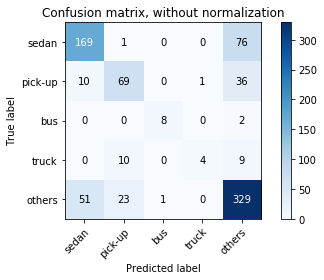

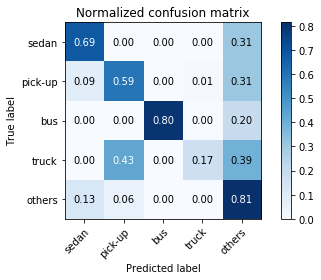

In [98]:
from plot_cfs import plot_confusion_matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(labels, predicts, classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(labels, predicts, classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
from visualize_images import imshow